In [ ]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet201
from keras.layers import Dropout
from keras.layers import Dense
from keras import Model
from keras.optimizers import Adam

/home/csci8523/attan005/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


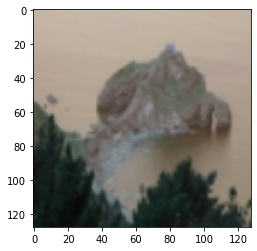

In [ ]:
class MyDataset():
    def __init__(self, csv_file_name, image_dir, min_samples_per_class, max_samples_per_class):
        self.min_samples_per_class = min_samples_per_class
        self.max_samples_per_class = max_samples_per_class
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_file_name)
        self.label = []
        self.image = []
        self.transform = []
        for i in range(self.data['landmark_id'].size):
            data_temp = self.data['images'][i].split()
            if(len(data_temp) > self.max_samples_per_class):
                random.shuffle(data_temp)
                data_temp = data_temp[0:self.max_samples_per_class]
            for j in data_temp:
                self.label.append(self.data['landmark_id'][i])
                self.image.append(j)
                self.transform.append(None)
            if(len(data_temp) < self.min_samples_per_class):
                num_aug = self.min_samples_per_class - len(data_temp)
                idx = 0
                while(num_aug != 0):
                    image_temp = data_temp[idx]
                    self.label.append(self.data['landmark_id'][i])
                    self.image.append(image_temp)
                    
                    brightness = random.random()
                    flip = random.randint(-1,1)
                    rotateang = random.randint(20,345)
                    augstring =str(brightness) + ' ' + str(flip) + ' ' + str(rotateang)


                    self.transform.append(augstring)
                    idx = idx + 1
                    if (idx >= len(data_temp)):
                        idx = 0
                    num_aug -= 1

    def augmentation(self, img, aug_string):
        img = img/255.
        if(aug_string != None):
            aug_par = aug_string.split()
            img = img*float(aug_par[0])
            img = cv2.flip(img, int(aug_par[1]))
            img = ndimage.rotate(img, int(aug_par[2]))

        imsize = img.shape
        img = cv2.copyMakeBorder(img, int((max(imsize)-imsize[0])/2), int(np.ceil((max(imsize)-imsize[0])/2)), int((max(imsize)-imsize[1])/2), int(np.ceil((max(imsize)-imsize[1])/2)), cv2.BORDER_CONSTANT)
        img = cv2.resize(img, (128,128))

        return img
         
        
    def __getitem__(self, index):
        item_label = self.label[index]
        item_image = cv2.imread(self.image_dir + self.image[index], 1)
        item_image = self.augmentation(item_image, self.transform[index])
        return item_label, item_image

    def __len__(self):
        return len(self.label)



train = MyDataset('train_clean_3.csv', './train_images_model_3/', 120, 400)

data_size = len(train) 

label, image = train[4] 
plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
train_data = pd.read_csv("train_clean_3.csv")
train_data.tail()
#image_ids = range(1, 117)

,landmark_id,images
111,112,d1ef993b0a4587fb.jpg d7cf81b973938324.jpg a138...
112,113,609b97d97c824a6e.jpg 10c0f7fa0f40e590.jpg 459c...
113,114,41399dc0135c5709.jpg 1f8be9077bcdb15b.jpg 7cb3...
114,115,b489a0896cfa7b1c.jpg 312a9cf81d59c6c7.jpg d9f4...
115,116,b1.jpg b2.jpg b3.jpg b4.jpg b5.jpg b6.jpg b7.j...


In [ ]:
x_train = []
y_train = []

for i in range(data_size):
    label, image = train[i]
    targets = np.zeros(116)
    targets[label-1] = 1
    x_train.append(image)
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)
print(x_train.shape)
print(y_train.shape)

(16979, 128, 128, 3)
(16979, 116)


In [ ]:
shuffled_data = list(zip(x_train,y_train))
random.shuffle(shuffled_data)

x_data, y_data = zip(*shuffled_data)
x_data = np.array(x_data)
y_data = np.array(y_data)
print('Images data size: ', x_data.shape)
print('Image labels size: ', y_data.shape)

Images data size:  (16979, 128, 128, 3)
Image labels size:  (16979, 116)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state=101)

print("x train data : ", len(x_train))
print("x val data : ", len(x_val))
print("y train data : ", len(y_train))
print("y val data : ", len(y_val))

x train data :  13583
x val data :  3396
y train data :  13583
y val data :  3396


In [ ]:
datagenerator_train = ImageDataGenerator()

In [ ]:
pretrained_model = DenseNet201(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='max')
pretrained_model.trainable = False

In [ ]:
input_layer = pretrained_model.input
dropout_layer = Dropout(0.25)(pretrained_model.output)
dense_layer_1 = Dense(512, activation='relu')(dropout_layer)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
dropout_layer_1 = Dropout(0.20)(dense_layer_2)
output_layer = Dense(116, activation='softmax')(dropout_layer_1)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
425/425 [==============================] - 167s 375ms/step - loss: 4.4651 - accuracy: 0.0547 - val_loss: 4.0080 - val_accuracy: 0.1184
Epoch 2/15
425/425 [==============================] - 153s 359ms/step - loss: 3.9014 - accuracy: 0.1220 - val_loss: 3.5717 - val_accuracy: 0.1914
Epoch 3/15
425/425 [==============================] - 156s 367ms/step - loss: 3.5294 - accuracy: 0.1766 - val_loss: 3.2808 - val_accuracy: 0.2412
Epoch 4/15
425/425 [==============================] - 157s 370ms/step - loss: 3.2946 - accuracy: 0.2146 - val_loss: 3.0925 - val_accuracy: 0.2750
Epoch 5/15
425/425 [==============================] - 153s 360ms/step - loss: 3.1183 - accuracy: 0.2494 - val_loss: 2.9734 - val_accuracy: 0.2980
Epoch 6/15
425/425 [==============================] - 155s 365ms/step - loss: 2.9557 - accuracy: 0.2818 - val_loss: 2.8968 - val_accuracy: 0.3118
Epoch 7/15
425/425 [==============================] - 158s 373ms/step - loss: 2.8297 - accuracy: 0.3086 - val_loss: 2.8435 -

In [ ]:
model.save_weights("model_dense_ka_21.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
425/425 [==============================] - 166s 374ms/step - loss: 2.0985 - accuracy: 0.4579 - val_loss: 2.7934 - val_accuracy: 0.3725
Epoch 2/15
425/425 [==============================] - 157s 369ms/step - loss: 2.0193 - accuracy: 0.4760 - val_loss: 2.7756 - val_accuracy: 0.3707
Epoch 3/15
425/425 [==============================] - 160s 376ms/step - loss: 1.9663 - accuracy: 0.4852 - val_loss: 2.8171 - val_accuracy: 0.3749
Epoch 4/15
425/425 [==============================] - 153s 359ms/step - loss: 1.9259 - accuracy: 0.4988 - val_loss: 2.7695 - val_accuracy: 0.3831
Epoch 5/15
425/425 [==============================] - 160s 376ms/step - loss: 1.8733 - accuracy: 0.5103 - val_loss: 2.7708 - val_accuracy: 0.3869
Epoch 6/15
425/425 [==============================] - 162s 382ms/step - loss: 1.8479 - accuracy: 0.5144 - val_loss: 2.8117 - val_accuracy: 0.3863
Epoch 7/15
425/425 [==============================] - 160s 375ms/step - loss: 1.7907 - accuracy: 0.5279 - val_loss: 2.8790 -

In [ ]:
model.save_weights("model_dense_ka_22.h5")

In [ ]:
for layer in pretrained_model.layers[:101]:
   layer.trainable = False
for layer in pretrained_model.layers[101:]:
   layer.trainable = True
input_layer = pretrained_model.input
dropout_layer_1 = Dropout(0.25)(pretrained_model.output)
dense_layer_1 = Dense(512, activation='relu')(dropout_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
dropout_layer_2 = Dropout(0.20)(dense_layer_2)
output_layer = Dense(116, activation='softmax')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_dense_ka_22.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
425/425 [==============================] - 491s 1s/step - loss: 4.1292 - accuracy: 0.1049 - val_loss: 3.7118 - val_accuracy: 0.1702
Epoch 2/15
425/425 [==============================] - 443s 1s/step - loss: 3.5196 - accuracy: 0.1900 - val_loss: 3.5960 - val_accuracy: 0.2064
Epoch 3/15
425/425 [==============================] - 447s 1s/step - loss: 3.2743 - accuracy: 0.2353 - val_loss: 4.0423 - val_accuracy: 0.1717
Epoch 4/15
425/425 [==============================] - 446s 1s/step - loss: 3.2193 - accuracy: 0.2402 - val_loss: 3.0805 - val_accuracy: 0.2933
Epoch 5/15
425/425 [==============================] - 444s 1s/step - loss: 3.1793 - accuracy: 0.2524 - val_loss: 3.0121 - val_accuracy: 0.2965
Epoch 6/15
425/425 [==============================] - 444s 1s/step - loss: 2.9315 - accuracy: 0.2965 - val_loss: 2.8648 - val_accuracy: 0.3295
Epoch 7/15
425/425 [==============================] - 443s 1s/step - loss: 2.8133 - accuracy: 0.3194 - val_loss: 3.2270 - val_accuracy: 0.2762

In [ ]:
model.save_weights("model_dense_pre_ka_21.h5")

In [ ]:
for layer in pretrained_model.layers[:101]:
   layer.trainable = False
for layer in pretrained_model.layers[101:]:
   layer.trainable = True
input_layer = pretrained_model.input
dropout_layer_1 = Dropout(0.25)(pretrained_model.output)
dense_layer_1 = Dense(512, activation='relu')(dropout_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
dropout_layer_2 = Dropout(0.20)(dense_layer_2)
output_layer = Dense(116, activation='softmax')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_dense_pre_ka_21.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
425/425 [==============================] - 496s 1s/step - loss: 2.5528 - accuracy: 0.3800 - val_loss: 2.5318 - val_accuracy: 0.3990
Epoch 2/15
425/425 [==============================] - 474s 1s/step - loss: 2.5259 - accuracy: 0.3774 - val_loss: 2.4655 - val_accuracy: 0.3916
Epoch 3/15
425/425 [==============================] - 475s 1s/step - loss: 2.4591 - accuracy: 0.3945 - val_loss: 2.3134 - val_accuracy: 0.4284
Epoch 4/15
425/425 [==============================] - 476s 1s/step - loss: 2.5348 - accuracy: 0.3779 - val_loss: 2.6933 - val_accuracy: 0.3749
Epoch 5/15
425/425 [==============================] - 481s 1s/step - loss: 2.3973 - accuracy: 0.4055 - val_loss: 2.4083 - val_accuracy: 0.4161
Epoch 6/15
425/425 [==============================] - 482s 1s/step - loss: 2.2495 - accuracy: 0.4361 - val_loss: 2.9159 - val_accuracy: 0.3245
Epoch 7/15
425/425 [==============================] - 478s 1s/step - loss: 2.1991 - accuracy: 0.4476 - val_loss: 2.2311 - val_accuracy: 0.4573

In [ ]:
model.save_weights("model_dense_pre_ka_22.h5")

In [ ]:
for layer in pretrained_model.layers[:101]:
   layer.trainable = False
for layer in pretrained_model.layers[101:]:
   layer.trainable = True
input_layer = pretrained_model.input
dropout_layer_1 = Dropout(0.25)(pretrained_model.output)
dense_layer_1 = Dense(512, activation='relu')(dropout_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
dropout_layer_2 = Dropout(0.20)(dense_layer_2)
output_layer = Dense(116, activation='softmax')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_dense_pre_ka_22.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 487s 1s/step - loss: 2.0319 - accuracy: 0.4964 - val_loss: 1.7545 - val_accuracy: 0.5518
Epoch 2/5
425/425 [==============================] - 466s 1s/step - loss: 1.8867 - accuracy: 0.5253 - val_loss: 2.1934 - val_accuracy: 0.4714
Epoch 3/5
425/425 [==============================] - 461s 1s/step - loss: 1.7271 - accuracy: 0.5491 - val_loss: 1.9194 - val_accuracy: 0.5309
Epoch 4/5
425/425 [==============================] - 463s 1s/step - loss: 1.6764 - accuracy: 0.5619 - val_loss: 1.6978 - val_accuracy: 0.5733
Epoch 5/5
425/425 [==============================] - 469s 1s/step - loss: 1.5906 - accuracy: 0.5812 - val_loss: 3.6679 - val_accuracy: 0.3416


In [ ]:
model.save_weights("model_dense_pre_ka_23.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 480s 1s/step - loss: 1.6210 - accuracy: 0.5773 - val_loss: 2.0099 - val_accuracy: 0.5133
Epoch 2/5
425/425 [==============================] - 462s 1s/step - loss: 1.5071 - accuracy: 0.6052 - val_loss: 1.8914 - val_accuracy: 0.5577
Epoch 3/5
425/425 [==============================] - 459s 1s/step - loss: 1.3970 - accuracy: 0.6285 - val_loss: 1.8005 - val_accuracy: 0.5586
Epoch 4/5
425/425 [==============================] - 461s 1s/step - loss: 1.4700 - accuracy: 0.6117 - val_loss: 1.8446 - val_accuracy: 0.5551
Epoch 5/5
425/425 [==============================] - 467s 1s/step - loss: 1.3397 - accuracy: 0.6421 - val_loss: 1.9099 - val_accuracy: 0.5495


In [ ]:
model.save_weights("model_dense_pre_ka_24.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 480s 1s/step - loss: 1.2782 - accuracy: 0.6598 - val_loss: 1.7880 - val_accuracy: 0.5612
Epoch 2/5
425/425 [==============================] - 461s 1s/step - loss: 1.2211 - accuracy: 0.6701 - val_loss: 1.9552 - val_accuracy: 0.5506
Epoch 3/5
425/425 [==============================] - 465s 1s/step - loss: 1.2302 - accuracy: 0.6744 - val_loss: 1.9360 - val_accuracy: 0.5651
Epoch 4/5
425/425 [==============================] - 466s 1s/step - loss: 1.0511 - accuracy: 0.7177 - val_loss: 1.9478 - val_accuracy: 0.5595
Epoch 5/5
425/425 [==============================] - 464s 1s/step - loss: 1.0476 - accuracy: 0.7163 - val_loss: 2.2143 - val_accuracy: 0.5256


In [ ]:
model.save_weights("model_dense_pre_ka_25.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 478s 1s/step - loss: 1.0794 - accuracy: 0.7079 - val_loss: 2.0468 - val_accuracy: 0.5536
Epoch 2/5
425/425 [==============================] - 461s 1s/step - loss: 0.9309 - accuracy: 0.7481 - val_loss: 2.0646 - val_accuracy: 0.5615
Epoch 3/5
425/425 [==============================] - 460s 1s/step - loss: 0.8759 - accuracy: 0.7618 - val_loss: 2.1590 - val_accuracy: 0.5542
Epoch 4/5
425/425 [==============================] - 461s 1s/step - loss: 1.0050 - accuracy: 0.7260 - val_loss: 2.6587 - val_accuracy: 0.4582
Epoch 5/5
425/425 [==============================] - 466s 1s/step - loss: 0.8982 - accuracy: 0.7567 - val_loss: 2.1485 - val_accuracy: 0.5639


In [ ]:
model.save_weights("model_dense_pre_ka_26.h5")

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 487s 1s/step - loss: 0.9174 - accuracy: 0.7552 - val_loss: 2.2420 - val_accuracy: 0.5292
Epoch 2/5
425/425 [==============================] - 463s 1s/step - loss: 0.8806 - accuracy: 0.7612 - val_loss: 2.2608 - val_accuracy: 0.5495
Epoch 3/5
425/425 [==============================] - 466s 1s/step - loss: 0.7968 - accuracy: 0.7846 - val_loss: 2.7749 - val_accuracy: 0.4482
Epoch 4/5
425/425 [==============================] - 463s 1s/step - loss: 0.8216 - accuracy: 0.7772 - val_loss: 2.9996 - val_accuracy: 0.4046
Epoch 5/5
425/425 [==============================] - 466s 1s/step - loss: 0.8851 - accuracy: 0.7614 - val_loss: 2.4301 - val_accuracy: 0.5371


In [ ]:
model.save_weights("model_dense_pre_ka_27.h5")

In [ ]:
for layer in pretrained_model.layers[:101]:
   layer.trainable = False
for layer in pretrained_model.layers[101:]:
   layer.trainable = True
input_layer = pretrained_model.input
dropout_layer_1 = Dropout(0.25)(pretrained_model.output)
dense_layer_1 = Dense(512, activation='relu')(dropout_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)
dropout_layer_2 = Dropout(0.20)(dense_layer_2)
output_layer = Dense(116, activation='softmax')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_dense_pre_ka_27.h5")

In [ ]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagenerator_train.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
425/425 [==============================] - 627s 1s/step - loss: 1.2894 - accuracy: 0.6935 - val_loss: 1.0820 - val_accuracy: 0.7556
Epoch 2/5
425/425 [==============================] - 599s 1s/step - loss: 1.0803 - accuracy: 0.7330 - val_loss: 1.0112 - val_accuracy: 0.7686
Epoch 3/5
425/425 [==============================] - 602s 1s/step - loss: 0.9755 - accuracy: 0.7573 - val_loss: 1.0467 - val_accuracy: 0.7582
Epoch 4/5
425/425 [==============================] - 599s 1s/step - loss: 0.8577 - accuracy: 0.7765 - val_loss: 0.9426 - val_accuracy: 0.7806
Epoch 5/5
425/425 [==============================] - 599s 1s/step - loss: 0.7652 - accuracy: 0.7972 - val_loss: 0.9359 - val_accuracy: 0.7856


In [ ]:
model.save_weights("model_dense_pre_ka_28.h5")

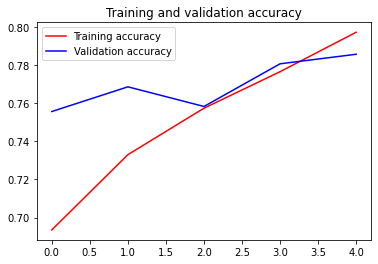

<Figure size 432x288 with 0 Axes>

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

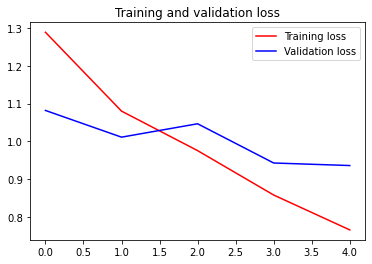

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
valdf = pd.read_csv("val_clean_3.csv")
images_pixels = []
temp_labels = []
y_test_ids = []
for ind in valdf.index:
    img = valdf['images'][ind].split(" ")[:-1]
    for i in img:
        finalpath = "validation_images_model_3/"+i
        img_pix = cv2.imread(finalpath,1)
        images_pixels.append(cv2.resize(img_pix, (128,128)))
        temp_labels.append(str(valdf['landmark_id'][ind]-1))
        y_test_ids.append(i)
#print(y_test_ids)
shuffled_data = list(zip(images_pixels,temp_labels, y_test_ids))
random.shuffle(shuffled_data)

val_data, labels_data_val, y_test_ids = zip(*shuffled_data)
print('Images: ', len(val_data))
print('Image labels: ', len(labels_data_val))
X_data_val = np.array(val_data) / 255
Y_data_val =  to_categorical(labels_data_val, num_classes = 116) 

Images:  3690
Image labels:  3690


In [ ]:
import csv
y_pred = np.argmax(model.predict(X_data_val, batch_size = 64, verbose=2), axis=-1)
y_pred_conf = model.predict(X_data_val, batch_size = 64, verbose=2)
y_test = np.nonzero(Y_data_val)[1]
#y_test = np.subtract(y_test, 1)
with open("test_result_dense_ka_2.csv", 'w', encoding='UTF8', newline='') as tr:
    writer = csv.writer(tr)
    writer.writerow(["image_id", "pred_landmark", "true_landmark", "confidence_score"])
    for i in range(len(y_pred)):
        writer.writerow([y_test_ids[i], y_pred[i], y_test[i], np.max(y_pred_conf[i])])
            
print(y_pred)
print(y_test)

58/58 - 38s - 38s/epoch - 660ms/step
58/58 - 35s - 35s/epoch - 605ms/step
[ 52 109 109 ...  11  83  90]
[  5 109 109 ...  11  67  17]


In [ ]:
print(y_test)
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

[  5 109 109 ...  11  67  17]
Model predication accuracy: 0.553

Classification report:
               precision    recall  f1-score   support

           0       0.43      0.56      0.49        16
           1       0.40      0.22      0.29        18
           2       0.44      0.39      0.41        18
           3       0.16      0.27      0.20        15
           4       0.54      0.41      0.47        17
           5       0.59      0.40      0.47        43
           6       0.80      0.95      0.87        21
           7       0.56      0.58      0.57        26
           8       0.48      0.56      0.52        57
           9       0.63      0.73      0.68        49
          10       0.60      0.67      0.63        45
          11       0.82      0.77      0.80       115
          12       0.71      0.75      0.73        20
          13       0.25      0.28      0.26        18
          14       0.56      0.60      0.58        15
          15       0.26      0.31      0.29   